# Collaboration and Competition

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### Benchmark model

First a benchmark model is implemented. Therefore the multi agent problem is reformulated into a single DDPG problem. There is only one policy which receives both state vectors and outputs the actions of both agents. Also the critic receives both states and the actions of both actors.

In [5]:
class environment_single_wrapper():
    def __init__(self, env):
        self.env = env
        self.vector_observations = self.env
        self.brain_names = self.env.brain_names
        
    def reset(self, train_mode):
        self.env_info = self.env.reset(train_mode)
        return self
    
    def __getitem__(self, brain_name):
        self.env_info = self.env_info[brain_name]
        self.vector_observations = self.env_info.vector_observations.reshape(1,-1)
        self.rewards = np.array([sum(self.env_info.rewards)])
        self.local_done = np.array([max(self.env_info.local_done)])
        return self
    
    def step(self, action):
        self.env_info = self.env.step(action)
        return self

In [6]:
BUFFER_SIZE = 10000  # replay buffer size
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.98            # discount factor
TAU = 5e-4              # for soft update of target parameters
LR_ACTOR = 1e-4       # learning rate of the actor 
LR_CRITIC = 1e-4       # learning rate of the critic

In [7]:
from pi_network import PiNetwork
from q_network import QNetwork

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
critic = QNetwork(input_size=state_size*2+action_size*2, layer_size1=128, layer_size2=128, lr=LR_CRITIC)

from agent import  DeterministicActorCriticAgent
from noise import OUNoise, GaussianNoise
from replay_buffer import ReplayBuffer
from trainer import Trainer


memory = ReplayBuffer(state_size, BUFFER_SIZE , BATCH_SIZE, 1337)
#noise = OUNoise(action_size*2, 1, 1337, sigma_decay=0.999, sigma=0.5, sigma_min=0.025)
noise = GaussianNoise(action_size*2, 1, 1337, sigma=1.0, sigma_decay=0.999, sigma_min=0.05)
ac =  DeterministicActorCriticAgent(gamma=GAMMA, tau=TAU, batch_size=BATCH_SIZE, update_every=1,
                                   actor=actor, critic=critic, memory=memory, noise=noise)

trainer = Trainer(environment_single_wrapper(env), ac)

scores = trainer.train(10000)

Episode 0	Average Score: -0.01
Episode 1	Average Score: 0.04,   0.09

E:\github\maddpg\agent.py:117: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: -0.01,   -0.01
Episode 200	Average Score: -0.01,   -0.01
Episode 300	Average Score: -0.01,   -0.01
Episode 400	Average Score: -0.00,   -0.01
Episode 500	Average Score: 0.01,   -0.011
Episode 600	Average Score: -0.01,   -0.01
Episode 700	Average Score: 0.01,   -0.011
Episode 800	Average Score: -0.01,   -0.01
Episode 900	Average Score: -0.00,   -0.01
Episode 1000	Average Score: 0.00,   -0.01
Episode 1100	Average Score: 0.00,   -0.011
Episode 1200	Average Score: 0.03,   0.0911
Episode 1300	Average Score: 0.01,   -0.011
Episode 1400	Average Score: -0.01,   -0.01
Episode 1500	Average Score: -0.01,   -0.01
Episode 1600	Average Score: -0.01,   -0.01
Episode 1700	Average Score: -0.01,   -0.01
Episode 1800	Average Score: 0.02,   0.0911
Episode 1900	Average Score: -0.01,   -0.01
Episode 2000	Average Score: 0.00,   -0.011
Episode 2100	Average Score: 0.00,   -0.011
Episode 2200	Average Score: 0.01,   -0.011
Episode 2300	Average Score: 0.01,   -0.011
Episode 2400	Average 

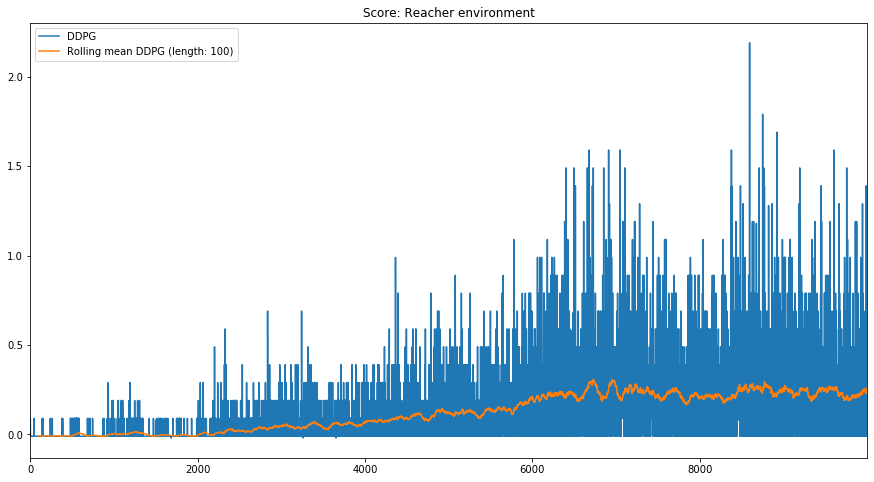

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


plt.figure(figsize=(15,8))
pd.Series(scores, name='DDPG').plot()
pd.Series(scores, name='Rolling mean DDPG (length: 100)').rolling(100).mean().plot()
plt.title('Score: Reacher environment')
plt.legend()

In [14]:
import torch
actor = trainer.agent.actor_local#.state_dict()

#import torch
path = './coop_policy_network_tennis'
#actor = trainer.agent.actor_local.state_dict()
#torch.save(trainer.agent.actor_local.state_dict(), path)

actor = PiNetwork(input_size=state_size*2, output_size=action_size*2, layer_size1=128, layer_size2=64, lr=LR_ACTOR)
actor.load_state_dict(torch.load(path))
actor.eval()

PiNetwork(
  (model): Sequential(
    (fc1): Linear(in_features=48, out_features=128, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (relu2): ReLU()
    (logits): Linear(in_features=64, out_features=4, bias=True)
    (tanh): Tanh()
  )
)

In [15]:
env = environment_single_wrapper(env)

In [16]:
mean_scores = []
for i in range(1, 100):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = actor(torch.from_numpy(states).float()).cpu().data.numpy()
        #actions = trainer.agent.act(states)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions[:2])[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
        mean_scores.append(np.max(scores))
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
print('Mean score over all episodes {}'.format(np.mean(mean_scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 5.200000077486038
Score (max over agents) from episode 3: 5.300000078976154
Score (max over agents) from episode 4: 3.090000046417117
Score (max over agents) from episode 5: 5.200000077486038
Score (max over agents) from episode 6: -0.009999999776482582
Score (max over agents) from episode 7: 5.200000077486038
Score (max over agents) from episode 8: 5.300000078976154
Score (max over agents) from episode 9: 3.1900000479072332
Score (max over agents) from episode 10: 5.200000077486038
Score (max over agents) from episode 11: 5.300000078976154
Score (max over agents) from episode 12: 5.200000077486038
Score (max over agents) from episode 13: 5.300000078976154
Score (max over agents) from episode 14: 1.6900000255554914
Score (max over agents) from episode 15: 5.200000077486038
Score (max over agents) from episode 16: 0.3900000061839819
Score (max over agents) from episode 17: 5.2000000774860